In [ ]:
pip install gymnasium

In [ ]:
pip install nevergrad

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [ ]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import nevergrad as ng

# creating mountain-car class

The specifications to note about representing the mountain-car MDP:

- the state is 2-dimensional and consists of x-axis position of the car as well as its velocity. Limits are $[-1.2, 0.6]$ for the position and $[-0.07, 0.07]$ for the velocity.
- the action is 1-dimensional and represents the force applied to the car. Limits are $[-1, 1]$.
- the reward is $100$ if the car reached the goal, i.e. its position is $>=0.45$ along the x-axis. For every timestep, a penalty of $0.1 * \mathrm{action}^2$ is also applied
- the car starts in the valley between the mountains at a location drawn uniformly at random between $-0.6$ & $-0.4$ and
$\gamma = 1$.
- the dynamics are given by the following equations:
$$v_{t+1} = v_t + a_t * \mathrm{power} - 0.0025 * \mathrm{cos}(3 * p_t)$$
$$p_{t+1} = p_t + v_{t+1}$$
(where $a_t$ is the current action, $p_t$ the current position, $v_t$ the current velocity, and $\mathrm{power}=0.0015$)
- the episode terminates if the the car reaches the goal or timestep 999 is reached

In [ ]:
class MountainCar:
  def __init__(self):
    self.min_pos = -1.2
    self.max_pos = 0.6
    self.min_v = -0.07
    self.max_v = 0.07
    self.power = 0.0015
    self.goal_pos = 0.45
    self.min_action = -1
    self.max_action = 1
    self.timestamp = 0
    self.state = None

  def reset(self, seed=None):
    # prepare for another episode
    seed_seq = np.random.SeedSequence(seed)
    self.rng = np.random.Generator(np.random.PCG64(seed_seq))  # using rng for sampling
    pos = self.rng.uniform(-0.6,-0.4)
    v = 0
    self.state = np.array([pos, v])
    return self.state

  def step(self, action):
    # performing single environment step
    pos, v = self.state
    force = min(max(action[0],self.min_action), self.max_action)
    v = v + (force*self.power) - 0.0025*np.cos(3*pos)
    v = np.clip(v, self.min_v, self.max_v)
    pos = pos + v
    pos = np.clip(pos, self.min_pos, self.max_pos)
    if pos == self.min_pos and v < 0:
      v = 0
    self.timestamp = self.timestamp +1
    done = bool(pos>=self.goal_pos or self.timestamp ==999)
    reward = 0
    if done:
      reward = 100
    reward = reward - 0.1*np.power(action[0],2)
    self.state = np.array([pos,v])
    return self.state, reward, done

## testing

We can check created MountainCar environment by seeding it (with 12345) and comparing it to the gymnasium implementation (that is seeded to the same random seed) on the provided action sequence (should yield the same state and reward sequence).

In [ ]:
env_real = gym.make("MountainCarContinuous-v0",render_mode="rgb_array")
action_seq = np.load("action_seq.npy")

In [ ]:
# compare gym and your environment - they should yield the same state sequence
state, _ = env_real.reset(seed=12345)
for action in action_seq:
  next_state, reward, terminated, truncated, _ = env_real.step(action)
  print(state, next_state)
  if terminated or truncated:
    break
  state = next_state
env_real.close()

[-0.55453277  0.        ] [-0.5558011  -0.00126833]
[-0.5558011  -0.00126833] [-0.5583283  -0.00252719]
[-0.5583283  -0.00252719] [-0.56209546 -0.00376719]
[-0.56209546 -0.00376719] [-0.56707454 -0.0049791 ]
[-0.56707454 -0.0049791 ] [-0.5732285  -0.00615396]
[-0.5732285  -0.00615396] [-0.58051157 -0.00728311]
[-0.58051157 -0.00728311] [-0.5888699  -0.00835833]
[-0.5888699  -0.00835833] [-0.59824187 -0.00937192]
[-0.59824187 -0.00937192] [-0.60855865 -0.01031676]
[-0.60855865 -0.01031676] [-0.6197451  -0.01118644]
[-0.6197451  -0.01118644] [-0.63172036 -0.0119753 ]
[-0.63172036 -0.0119753 ] [-0.6443989  -0.01267854]
[-0.6443989  -0.01267854] [-0.6576912  -0.01329224]
[-0.6576912  -0.01329224] [-0.6715046  -0.01381345]
[-0.6715046  -0.01381345] [-0.6857448 -0.0142402]
[-0.6857448 -0.0142402] [-0.7003163 -0.0145715]
[-0.7003163 -0.0145715] [-0.71512365 -0.01480734]
[-0.71512365 -0.01480734] [-0.7300723  -0.01494864]
[-0.7300723  -0.01494864] [-0.74506956 -0.01499723]
[-0.74506956 -0.0149

In [ ]:
env_mc = MountainCar()
state = env_mc.reset(seed=12345)
for action in action_seq:
  next_state, reward, done = env_mc.step(action)
  print(state, next_state)
  if done:
    break
  state = next_state

[-0.5545328  0.       ] [-0.55580112 -0.00126833]
[-0.55580112 -0.00126833] [-0.55832831 -0.00252719]
[-0.55832831 -0.00252719] [-0.56209549 -0.00376719]
[-0.56209549 -0.00376719] [-0.5670746 -0.0049791]
[-0.5670746 -0.0049791] [-0.57322855 -0.00615396]
[-0.57322855 -0.00615396] [-0.58051166 -0.00728311]
[-0.58051166 -0.00728311] [-0.58886999 -0.00835833]
[-0.58886999 -0.00835833] [-0.59824191 -0.00937192]
[-0.59824191 -0.00937192] [-0.60855867 -0.01031676]
[-0.60855867 -0.01031676] [-0.61974511 -0.01118644]
[-0.61974511 -0.01118644] [-0.63172041 -0.0119753 ]
[-0.63172041 -0.0119753 ] [-0.64439894 -0.01267853]
[-0.64439894 -0.01267853] [-0.65769118 -0.01329223]
[-0.65769118 -0.01329223] [-0.67150462 -0.01381345]
[-0.67150462 -0.01381345] [-0.68574482 -0.0142402 ]
[-0.68574482 -0.0142402 ] [-0.70031631 -0.0145715 ]
[-0.70031631 -0.0145715 ] [-0.71512365 -0.01480733]
[-0.71512365 -0.01480733] [-0.73007229 -0.01494864]
[-0.73007229 -0.01494864] [-0.74506952 -0.01499723]
[-0.74506952 -0.01

## Model-based RL

Now we try and solve this MDP - we opt for a model-based RL algorithm, meaning that we use an explicitly trained model of the transition dynamics. To this end, we collect data from the environment in the form of $(s,a,s',r)$ tuples, train the surrogate model $\hat{T}$ to replicate the state transition dynamics and later use it to derive a policy $\pi:S \rightarrow A$, such that we reach the goal to maximize the return.

In this section we start by training a dynamics model in torch - it is recommended to train one model for each of the state dimensions and predict differences instead of absolute values (i.e. predict $\Delta v_t = v_{t+1} - v_t$ instead of $v_{t+1}$ directly).

* Since the environment is rather simple, roughly 10,000 interactions should suffice for data collection and 3 hidden layers of size 10 should be enough to capture the transition function.  
* Uniform random actions during collection and stop trajectories after 200 steps.
* Using the option of the gym environment to sample starting states uniformly in the whole range in $[-1.2, 0.6]$ for data collection (using only the standard range will require much more data collection to obtain accurate models since the edge regions are hard to reach under random actions).
* Splitting our data into 90 / 10 percent for training and validation.
* Expected an MSE validation error below $1e-6$.

## define the model

In [ ]:
class TransitionModel(torch.nn.Module):
  def __init__(self, state_dim, action_dim, hidden_dims):
    super(TransitionModel,self).__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dims[0])
    self.fc2 = torch.nn.Linear(hidden_dims[0],hidden_dims[1])
    self.fc3 = torch.nn.Linear(hidden_dims[1],hidden_dims[2])
    self.fc4 = torch.nn.Linear(hidden_dims[2], state_dim)

  def forward(self, state, action):
    x = torch.cat((state,action), dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return self.fc4(x)

## collect data

In [ ]:
# collect data for training
env = gym.make("MountainCarContinuous-v0")
num_interactions = 50
max_steps = 200
transitions = []

for _ in range(num_interactions):
  state, _ = env.reset(seed=12345)
  t = {'states':[], 'actions':[], 'next_states':[],'rewards':[]}
  for _ in range(max_steps):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    t['states'].append(state)
    t['actions'].append(action[0])
    t['next_states'].append(next_state)
    t['rewards'].append(reward)
    if terminated or truncated:
      break
    state = next_state
  transitions.append(t)
  train_size = int(0.9 * num_interactions)
  train = transitions[:train_size]
  valid = transitions[train_size:]


## train

In [ ]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dims = [10,10,10]
criterion = torch.nn.MSELoss()

def prepare_data(data):
  states = torch.tensor(data['states'], dtype=torch.float32)
  actions = torch.tensor(data['actions'], dtype=torch.float32)
  actions = torch.reshape(actions, (len(actions),1))
  next_states = torch.tensor(data['next_states'], dtype=torch.float32)
  #r = torch.tensor(data['rewards'], dtype=torch.float32)
  #rewards = torch.reshape(r, (len(r),1))
  return states, actions, next_states #, rewards

training a model for the position variable *p*

In [ ]:
# instantiate transition models and train them
pModel = TransitionModel(state_dim, action_dim, hidden_dims)
optimizer = torch.optim.Adam(pModel.parameters(), lr=0.001)
for e in range(10):
  pModel.train()
  train_loss = 0
  for t in train:
    s, a, ns = prepare_data(t)
    optimizer.zero_grad()
    pred = pModel(s, a)
    loss = criterion(pred[:,:1], ns[:,:1]-s[:,:1])
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  pModel.eval()
  val_loss = 0
  with torch.no_grad():
    for v in valid:
      s, a, ns = prepare_data(v)
      pred = pModel(s,a)
      loss = criterion(pred[:,:1], ns[:,:1]-s[:,:1])
      val_loss += loss.item()

  print(f'Epoch [{e + 1}/{10}], Training Loss: {train_loss / len(train)}, Validation Loss:{val_loss/len(valid)}')


training another model for velocity *v*

In [ ]:
vModel = TransitionModel(state_dim, action_dim, hidden_dims)
optimizer = torch.optim.Adam(vModel.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
  vModel.train()
  total_loss = 0
  for t in train:
    s, a, ns = prepare_data(t)
    optimizer.zero_grad()
    pred = vModel(s, a)
    loss = criterion(pred[:,:2], ns[:,:2]-s[:,:2])
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  vModel.eval()
  val_loss = 0
  with torch.no_grad():
    for v in valid:
      s, a, ns = prepare_data(v)
      pred = vModel(s,a)
      loss = criterion(pred[:,:2], ns[:,:2]-s[:,:2])
      val_loss += loss.item()
  print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {total_loss / len(train)}, Validation Loss:{val_loss/len(valid)}')

saving models

In [ ]:
torch.save(pModel, 'pModel.pt')
torch.save(vModel, 'vModel.pt')
#pModel = torch.load('pModel.pt')
#vModel = torch.load('vModel.pt')

## Model testing

To check, we first build a compound model that encapsulates both predictions into one, i.e. it takes in state and action and returns a full state consisting of both position and velocity.

We use the simple_policy to collect episodes in the real environment & use the same starting state and actions to collect a "virtual" / "imagined" episode. They need not be identical since our model cannot be perfect (however they should be quite similar and both should reach the goal within ~100 steps with the simple policy).

## compound model

In [ ]:
class CompoundModel:
  def __init__(self, pModel, vModel):
    self.pModel = pModel
    self.vModel = vModel

  def predict(self, state, action, return_torch=False):
    a = torch.FloatTensor(action)
    print(len(a))
    ac = torch.reshape(a, (len(a),1))
    s = torch.FloatTensor(state)
    print(len(s))
    st = torch.reshape(s, (len(s),2))
    delta_pos = self.pModel(st, ac)
    delta_vel = self.vModel(st, ac)
    next_pos = state[0] + delta_pos.data[0][0].numpy()
    next_vel = state[1] + delta_vel.data[0][1].numpy()
    next_state_numpy = np.array([next_pos, next_vel])
    return next_state_numpy

## test in trajectories

In [ ]:
simple_policy = lambda x: np.array([1.]) if x[1] > 0. else np.array([-1.])

In [ ]:
# use the gym env to compare state sequences obtained by environment and surrogate model when executing the same actions
env = gym.make("MountainCarContinuous-v0")
model = CompoundModel(pModel, vModel)
goal_position = 0.45
s, _ = env.reset(seed=42)
state = s

for _ in range(100):
  action = simple_policy(state)
  next_state = model.predict(state, action)
  print(state, next_state)
  done = bool(next_state[0] >= goal_position)
  if done:
    print("Terminated")
    break
  state = next_state

In [ ]:
state = s
for _ in range(100):
  action = simple_policy(state)
  next_state, reward, terminated, truncated, _ = env.step(action)
  print(state, next_state)
  if terminated or truncated:
    print("Terminated")
    break
  state = next_state
env.close()

[-0.4452088  0.       ] [-0.4472913  -0.00208252]
[-0.4472913  -0.00208252] [-0.45144117 -0.00414984]
[-0.45144117 -0.00414984] [-0.45762798 -0.00618681]
[-0.45762798 -0.00618681] [-0.46580634 -0.00817836]
[-0.46580634 -0.00817836] [-0.47591597 -0.01010964]
[-0.47591597 -0.01010964] [-0.48788202 -0.01196604]
[-0.48788202 -0.01196604] [-0.5016154 -0.0137334]
[-0.5016154 -0.0137334] [-0.51701355 -0.01539816]
[-0.51701355 -0.01539816] [-0.5339611  -0.01694755]
[-0.5339611  -0.01694755] [-0.552331   -0.01836984]
[-0.552331   -0.01836984] [-0.5719856  -0.01965462]
[-0.5719856  -0.01965462] [-0.59277856 -0.02079299]
[-0.59277856 -0.02079299] [-0.61455643 -0.02177786]
[-0.61455643 -0.02177786] [-0.63716054 -0.02260411]
[-0.63716054 -0.02260411] [-0.6604293  -0.02326878]
[-0.6604293  -0.02326878] [-0.6842004  -0.02377113]
[-0.6842004  -0.02377113] [-0.7083131  -0.02411268]
[-0.7083131  -0.02411268] [-0.7326102  -0.02429714]
[-0.7326102  -0.02429714] [-0.7569405  -0.02433028]
[-0.7569405  -0.02

## Policy model

next, we want to use the trained transition model to derive a closed form policy $\pi:S \rightarrow A$ to solve the problem. First, define a neural network policy model in torch - a single layer of 20 hidden units should suffice for this simple problem.

In [ ]:
class PolicyModel(torch.nn.Module):
  def __init__(self, state_dim, action_dim, hidden_dim):
    super(PolicyModel, self).__init__()
    self.i = nn.Linear(state_dim, hidden_dim)
    self.out = nn.Linear(hidden_dim, action_dim)

  def forward(self, state):
    x = F.relu(self.i(state))
    action = F.tanh(self.out(x))
    return action

## define rollouts

Next, we'll need a way to use the model to assess the policy's performance. To do so,

* We sample start states from the from the dataset and perform imagined episodes from there on out by following the policy actions and using the dynamics model's state predictions.

* We use our knowledge about the environment and directly declare any of the episodes that reach the goal as success.

* The rollout function returns the ratio of episodes that resulted in success

In [ ]:
def rollout(policy, dynamics, steps, start_states):
  success_count = 0
  for _ in range(steps):
      actions = policy(start_states)
      next_states = dynamics.predict(start_states, actions)
      success_states = [ns for ns in next_states if ns[0]>=0.45]
      success_count += len(success_states)
      nstates = np.array([ns for ns in next_states if ns not in success_states])
      start_states = torch.tensor(nstates, dtype=torch.float32)
  success_ratio = success_count / len(start_states)
  return success_ratio

## policy training

for the final policy training, we go for a gradient-free optimization technique, since gradient based approaches can exhibit unstable behavior in the model based setting with sparse rewards. For this we first need a fitness function, i.e. a function that receives the paramaters of the policy as a flat weight array in numpy and returns the fitness of this policy, i.e. its above defined success ratio:

In [ ]:
def sampleState():
  pos = np.random.uniform(-1.2, 0.6, 1)
  vel = 0.0
  x = np.array([pos[0], vel])
  return torch.reshape(torch.FloatTensor(x), (1,2))

In [ ]:
def fitness(param_vec, batchsize=100, horizon=100):
  state_dim = 2
  action_dim = 1
  hidden_dim = 20
  start_states = torch.empty((0, 2), dtype=torch.float32)
  for _ in range(batchsize):
    state = sampleState()
    print(state.size())
    print(start_states.size())
    start_states = torch.cat((start_states, state), dim=0)
  policy = PolicyModel(state_dim, action_dim, hidden_dim)
  stateDict = policy.state_dict()
  for weight, p in zip(policy.state_dict(), param_vec):
    stateDict[f"{weight}"] = p
  dynamics = CompoundModel(pModel,vModel)
  fitness = rollout(policy, dynamics, horizon, torch.as_tensor(start_states))
  return fitness

finally, use the nevergrad library (https://facebookresearch.github.io/nevergrad/getting_started.html) to find well performing weights. Note: A budget of 5000 and rollouts of length 100 is usually plenty to derive a good policy.

In [ ]:
# train policy using nevergrad
w1=ng.p.Array(shape=(20,2)),
b1=ng.p.Array(shape=(20,)),
w2=ng.p.Array(shape=(1,20)),
b2=ng.p.Array(shape=(1,))
params= ng.p.Tuple(w1,b1,w2,b2)
instru = ng.p.Instrumentation(param_vec=params)
optimizer = ng.optimizers.NGOpt(parametrization=instru, budget=500)
recommendation = optimizer.minimize(fitness)

In [ ]:
np.save("policy.npy", recommendation.value[1])

In [ ]:
def params_from_ng(recommendation):
  w = np.load(recommendation, allow_pickle=True)
  params = []
  for i in w.item()['param_vec']:
    if(type(i)==tuple):
      x = np.array(i[0].value)
      x = torch.tensor(x, dtype=torch.float32)
    else:
      x = np.array(i[0])
      x = torch.tensor(x, dtype=torch.float32)
      x = torch.reshape(x, (1,))
    params.append(x)
  return params

## test policy

We can test whether the policy that you found with nevergrad actually performs well in the real environment too - note that we trained on a surrogate of the environment that is not perfect. We use the policy to make at least 100 episodes of length 100 to get a decent estimate of the performance.

In [ ]:
def sample_weights(input_dim, hidden_units, output_dim):
    W1 = 2 * torch.rand(hidden_units, input_dim) - 1
    b1 = 2 * torch.rand(hidden_units) - 1
    W2 = 2 * torch.rand(output_dim, hidden_units) - 1
    b2 = 2 * torch.rand(output_dim) - 1
    return W1, b1, W2, b2

In [ ]:
x = sample_weights(2,20,1)
for i in x:
  print(i.size())

In [ ]:
# test policy
env = gym.make("MountainCarContinuous-v0")
model = CompoundModel(pModel, vModel)
policy = PolicyModel(2,1,20)
stateDict = policy.state_dict()
#params = sample_weights(2,20,1)
params = params_from_ng('policy.npy')
for weight, p in zip(policy.state_dict(), params):
  stateDict[f"{weight}"] = p
episodes = 100
state, _ = env.reset()
count = 0
for episode in range(episodes):
  for _ in range(100):
    action = policy(torch.tensor(state, dtype= torch.float32))
    with torch.no_grad():
      next_state, reward, terminated, truncated, _ = env.step(action)
      if terminated or truncated:
        print(terminated, truncated)
        count+=1
        break
    state = next_state
print(count/100)
env.close()

## visualize

Since visualization in jupyter can be tricky, we write a small python script for it. We simply save the weights here and reload them in the script.

In [ ]:
#np.save("policy.npy", recommendation.value)
env = gym.make("MountainCarContinuous-v0",render_mode="rgb_array")

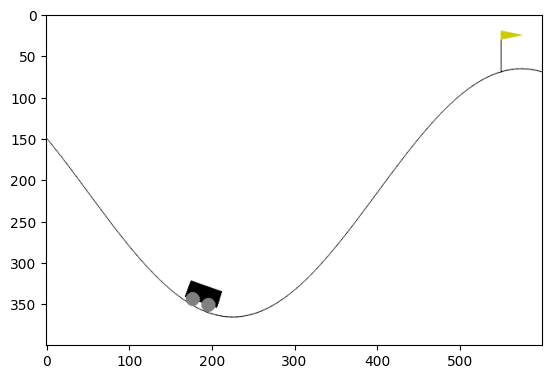

In [ ]:
from typing_extensions import TypeVarTuple
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
params = params_from_ng('policy.npy')
for weight, p in zip(policy.state_dict(), params):
  stateDict[f"{weight}"] = p
state, _ = env.reset()
a = env.render()
img = plt.imshow(a)
episode_length = 200
for _ in range(episode_length):
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = policy(torch.tensor(state, dtype= torch.float32))
    with torch.no_grad():
      next_state, _, terminated, truncated, _ = env.step(action)
      if terminated or truncated:
        print('Terminated')
        break
    state = next_state